#### Note: needing to join scores and labels with parameter df from Wandb is a temorary situation! (Not all data saved correctly to disk).

Once optimisations have been re-run, the final results will all be in one place...

In [131]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import wandb
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

from utilities import run_configs

%matplotlib inline

In [14]:
all_paths = {
    'best_bayes_search_runs_paths': {
        1: "rusty-chris/tune_shallow_clustering/zsm7m6j4",
    },
    # Ranodmized search explores the space more completely, and given that suboptimal clusterings may be preferable, might contain important data...
    'best_randomized_search_runs_paths': {
        1: "rusty-chris/tune_shallow_clustering/vphbjdan",  
        5: "rusty-chris/tune_shallow_clustering/sie9j576"  
    }
}

In [15]:
run_paths = 'best_randomized_search_runs_paths'

In [16]:
for key in all_paths[run_paths].keys():
    run_configs[key]['best_run_path'] = all_paths[run_paths][key]

In [17]:
run_id = 5

In [18]:
run_configs[run_id]

{'run_id': 0,
 'random_seed': 42,
 'dim_reducer': 'pca',
 'clustering_algo': 'kmeans',
 'data_path': '../data/cleaned_data_SYMPTOMS_9_13_23.csv',
 'optimiser_score': 'silhouette',
 'search_iter': 1000000,
 'best_run_path': 'rusty-chris/tune_shallow_clustering/sie9j576'}

In [19]:
api = wandb.Api(timeout=100)

In [20]:
run = api.run(run_configs[run_id]['best_run_path'])

In [21]:
pca_df = pd.DataFrame.from_dict(run.scan_history())

In [24]:
run_id = 1
api = wandb.Api(timeout=100)
run = api.run(run_configs[run_id]['best_run_path'])
umap_df = pd.DataFrame.from_dict(run.scan_history())

In [28]:
print(len(pca_df), len(umap_df))

8854 1538


In [29]:
with open('./results/pca_kmeans_silhouette_run_0_randomized/scores_and_labels_df.pickle', 'rb') as outfile:
    pca_scores = pk.load(outfile)

In [30]:
with open('./results/umap_kmeans_silhouette_run_0_randomized/scores_and_labels_df.pickle', 'rb') as outfile:
    umap_scores = pk.load(outfile)

In [89]:
join_on = ['silhouette']
pca = pca_scores.merge(pca_df, on=join_on, how='inner')
pca = pca.drop_duplicates(subset=['silhouette'])

umap = umap_scores.merge(umap_df, on=join_on, how='inner')
umap = umap.drop_duplicates(subset=['silhouette'])

In [90]:
print(len(pca), len(umap))

485 496


In [91]:
df = pca_df
p_keys = sorted([
    col.split('.')[1] for col in df.columns
    if 'current_params' in col
])

In [92]:
p_keys

['kmeans__init', 'kmeans__n_clusters', 'kmeans__n_init', 'pca__n_components']

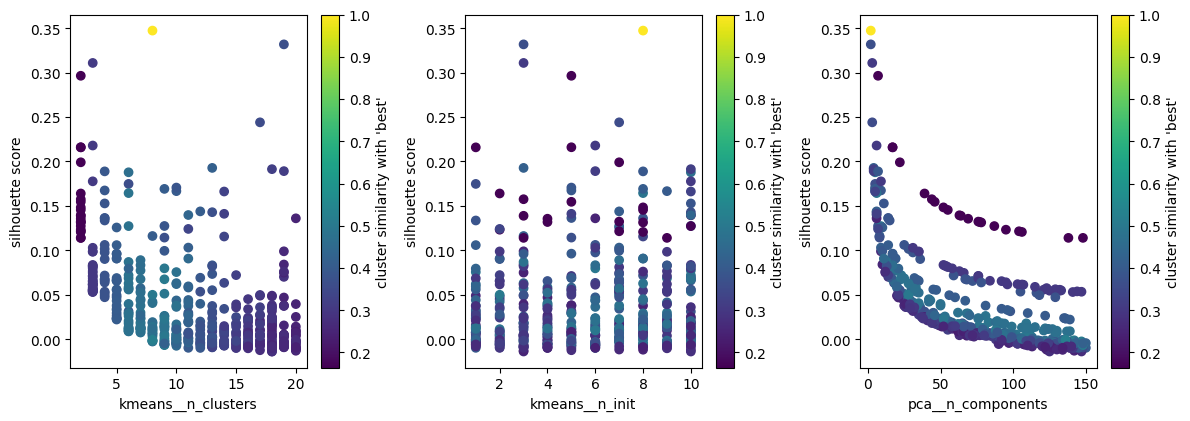

In [106]:
pi = 1
plt.figure(figsize=(12,8))
for param in p_keys:
    if param != 'kmeans__init':
        plt.subplot(2,3,pi)
        X = pca['current_params.' + param]
        plt.scatter(X, pca.silhouette, c=pca.rand_score_with_71_cc_8)
        cbar = plt.colorbar(label="cluster similarity with 'best'")
        plt.xlabel(param);
        plt.ylabel('silhouette score');
        pi += 1

plt.tight_layout()
# plt.savefig('./results/plots/partial_dependence_silhouette_color_adj_rand_279_%s.png' % run_name)

In [107]:
df = umap_df
p_keys = sorted([
    col.split('.')[1] for col in df.columns
    if 'current_params' in col
])

In [109]:
umap.columns

Index(['silhouette', 'dbcv_x', 'calinski_harabasz_x', 'davies_bouldin_x',
       'dbcv_minkowski_x', 'fraction_clustered', 'cluster_count_x', 'labels_x',
       'rand_score_with_454_cc_8', 'mi_score_with_454_cc_8',
       'rand_score_with_81_cc_10', 'mi_score_with_81_cc_10',
       'rand_score_with_323_cc_2', 'mi_score_with_323_cc_2',
       'rand_score_with_469_cc_9', 'mi_score_with_469_cc_9',
       'rand_score_with_39_cc_12', 'mi_score_with_39_cc_12',
       'rand_score_with_122_cc_13', 'mi_score_with_122_cc_13',
       'rand_score_with_408_cc_11', 'mi_score_with_408_cc_11',
       'rand_score_with_15_cc_4', 'mi_score_with_15_cc_4',
       'rand_score_with_165_cc_18', 'mi_score_with_165_cc_18',
       'rand_score_with_148_cc_17', 'mi_score_with_148_cc_17',
       'rand_score_with_415_cc_7', 'mi_score_with_415_cc_7',
       'rand_score_with_18_cc_15', 'mi_score_with_18_cc_15',
       'rand_score_with_283_cc_5', 'mi_score_with_283_cc_5',
       'rand_score_with_385_cc_19', 'mi_score_w

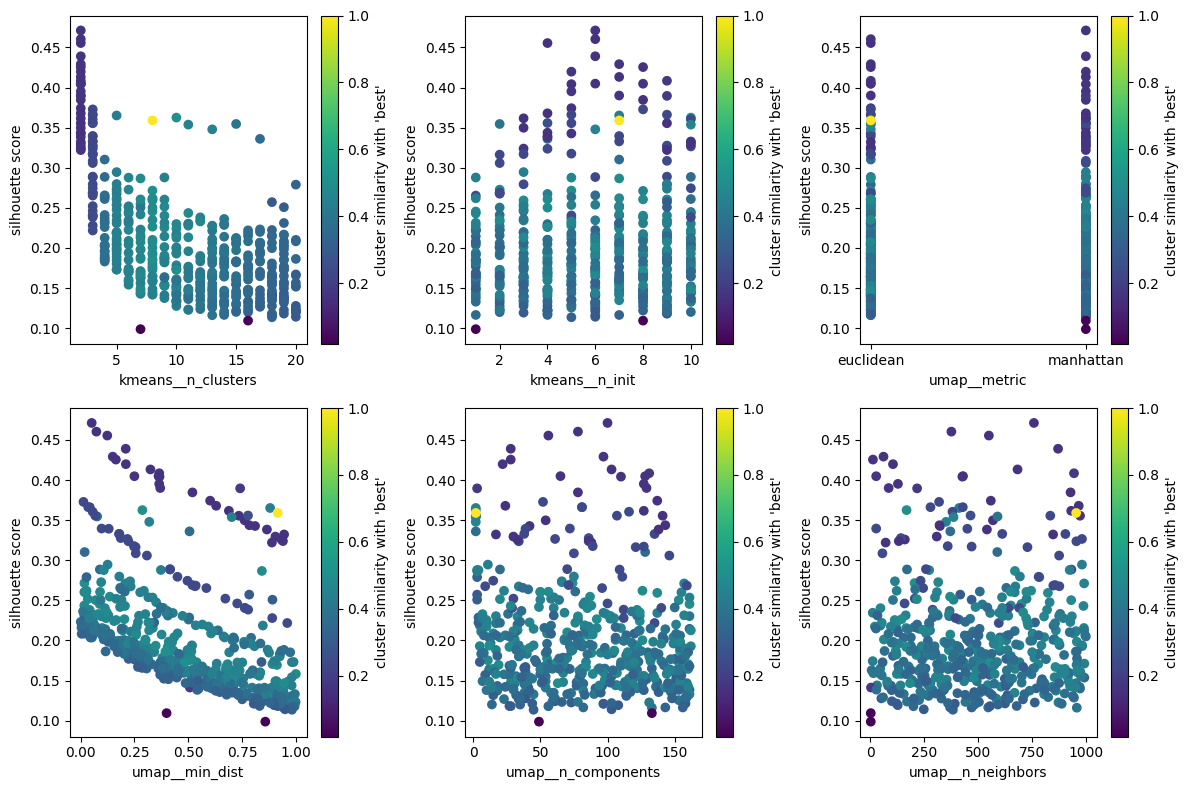

In [114]:
pi = 1
plt.figure(figsize=(12,8))
for param in p_keys:
    if param != 'kmeans__init':
        plt.subplot(2,3,pi)
        X = umap['current_params.' + param]
#         plt.scatter(X, umap.silhouette, c=umap.rand_score_with_323_cc_2)
#         plt.scatter(X, umap.silhouette, c=umap.rand_score_with_84_cc_3)
        plt.scatter(X, umap.silhouette, c=umap.rand_score_with_454_cc_8)
        cbar = plt.colorbar(label="cluster similarity with 'best'")
        plt.xlabel(param);
        plt.ylabel('silhouette score');
        pi += 1

plt.tight_layout()

##### We now look at the best N cluster structure for each PCA and UMAP and compare the two:

In [140]:
C = []
R = []
M = []
for cc in np.sort(umap.cluster_count_x.unique()):

    umap_best = umap[umap.cluster_count_x == cc].sort_values('silhouette', ascending=False).iloc[0].name
    pca_best = pca[pca.cluster_count_x == cc].sort_values('silhouette', ascending=False).iloc[0].name
    
    rand = adjusted_rand_score(pca.loc[pca_best].labels_x, umap.loc[umap_best].labels_x)
    mi = adjusted_mutual_info_score(pca.loc[pca_best].labels_x, umap.loc[umap_best].labels_x)
    R.append(rand)
    M.append(mi)
    C.append(cc)
    

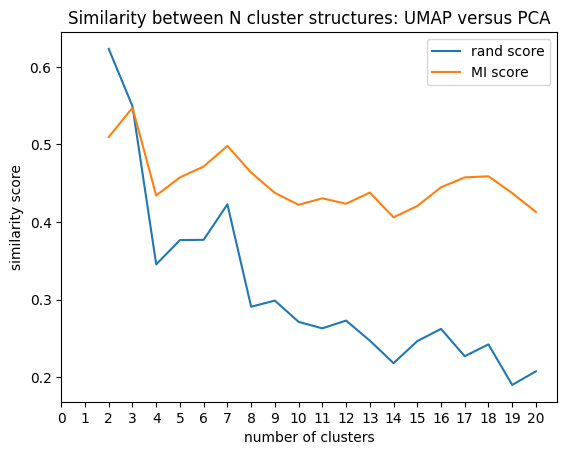

In [147]:
plt.plot(C, R, label='rand score')
plt.plot(C, M, label='MI score')
plt.xlabel('number of clusters')
plt.ylabel('similarity score')
plt.title('Similarity between N cluster structures: UMAP versus PCA')
plt.legend()
plt.xticks(ticks=range(21));

In [190]:
n_clusters = 7

In [191]:
umap_labels = umap[umap.cluster_count_x == n_clusters].sort_values('silhouette', ascending=False).iloc[0].labels_x

In [192]:
pca_labels = pca[pca.cluster_count_x == n_clusters].sort_values('silhouette', ascending=False).iloc[0].labels_x

In [193]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

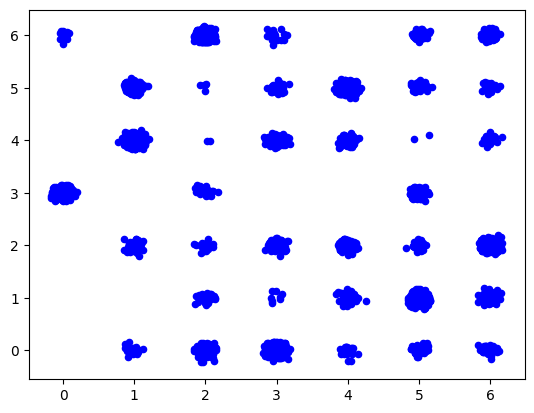

In [194]:
jitter(pca_labels, umap_labels);

In [195]:
from utilities import load_symptom_data
symptom_data = load_symptom_data(run_configs[run_id]['data_path'])

In [196]:
pca_labels = pd.DataFrame({
    'index': symptom_data.index,
    'cluster': pca_labels
})

In [197]:
pca_labels.to_csv('./results/pca_kmeans_silhouette_run_0_randomized/%d_cluster_labels_pca_kmeans_silhouette_TEMP.csv' % n_clusters, index=False)

In [198]:
umap_labels = pd.DataFrame({
    'index': symptom_data.index,
    'cluster': umap_labels
})

In [199]:
umap_labels.to_csv('./results/umap_kmeans_silhouette_run_0_randomized/%d_cluster_labels_umap_kmeans_silhouette_TEMP.csv' % n_clusters, index=False)

In [200]:
symptom_data

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,...,Symptom_SkinAllergy_itchy_skin,Symptom_SkinAllergy_itchy_eyes,Symptom_SkinAllergy_heighted_reaction_allergies,Symptom_SkinAllergy_brittle_nail,Symptom_SkinAllergy_other_itchy,Symptom_SkinAllergy_shingles,Symptom_PEM,Symptom_Fatigue,Symptom_Change_sensitivity_to_meds,Symptom_New_allergies
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,1
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,1,0,0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,1,0,1,0,0,1,1,1,0
14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,1,1,0,0
14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,1,0
14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
